# Robustness under assumption violations

for all methods

In [1]:
require('cowplot')
library('ggplot2')
source(file.path('..','commons','get_expected_pval_and_equiv_z.R'))
source(file.path('..','commons','multiplot.R'))
source(file.path('..','commons','plot_lib.R'))
source(file.path('..', 'commons','prepare_data.R'))
source(file.path('..', 'commons','plot_unit_mismatch.R'))
source(file.path('..', 'commons','plot_blandaldman_z.R'))
source(file.path('..', 'commons','plot_grid_methods_color_within.R'))
source(file.path('..', 'commons','plot_qq_p.R'))
theme_set(theme_gray()) # switch to default ggplot2 theme for good
theme_update(panel.background = element_rect(fill = "grey95"))
library(scales)

Loading required package: cowplot
Loading required package: ggplot2

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## One-sample tests

### Load data from CSV

In [2]:
allsimudat_k05 <- load_data_from_csv('^test1_k005_n20.*_nominal', '/Volumes/camille/IBMA_simu/')
allsimudat_k10 <- load_data_from_csv('^test1_k010_n20.*_nominal', '/Volumes/camille/IBMA_simu/')
allsimudat_k25 <- load_data_from_csv('^test1_k025_n20.*_nominal*', '/Volumes/camille/IBMA_simu/')
allsimudat_k50 <- load_data_from_csv('^test1_k050_n20.*_nominal*', '/Volumes/camille/IBMA_simu/')
allsimudat_k25_n100 <- load_data_from_csv('^test1_k025_n100_.*_nominal', '/Volumes/camille/IBMA_simu/')

[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k005_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k010_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k050_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test1_k025_n100__nominal.csv"


In [3]:
allsimudat <- rbind(
                    allsimudat_k05, 
                    allsimudat_k10, 
                    allsimudat_k25, 
                    allsimudat_k25_n100,
                    allsimudat_k50
)

### Figure

pdf 
  2

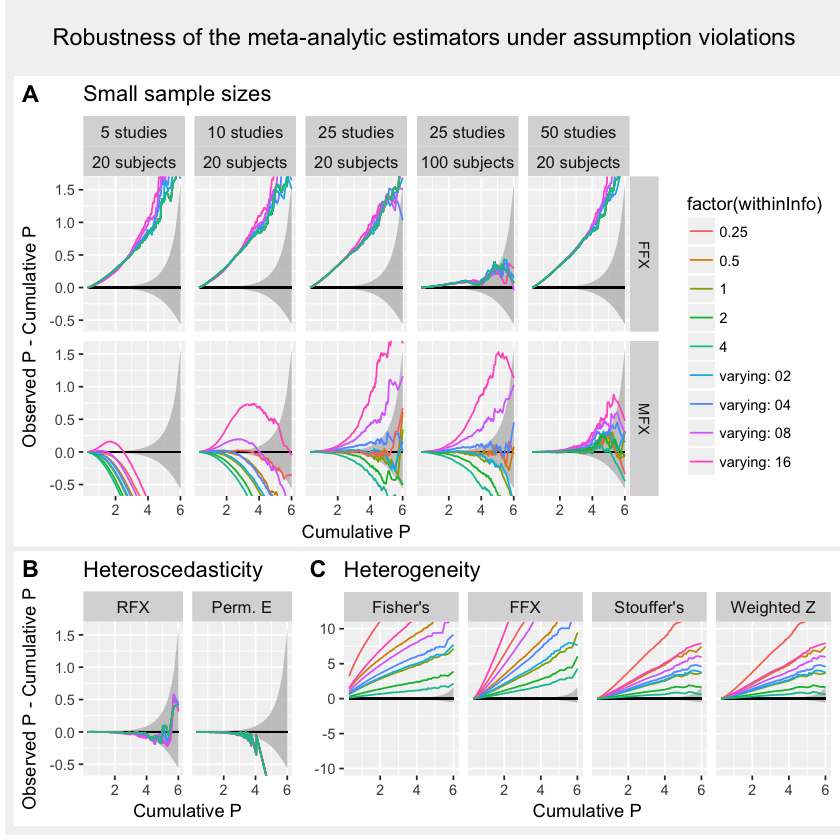

In [5]:
source(file.path('..', 'commons','plot_grid_methods_color_within.R'))
source(file.path('..', 'commons','plot_qq_p.R'))

# Create a three-panel figure investigating robustness under:
#  A. small sample sizes (FFX and MFX)
#  B. heteroscedasticity (RFX and contrast permutation)
#  C. heterogeneity (Fisher's, Stouffer's, FFX and Weighted Z)
robutness_plot <- function(data){
    data_positive_z <- subset(data, expectedz>0 & (unitMism=="nominal"))
        
    large_sample_methods <- c("megaMFX","megaFFX_FSL")
    homoscedasticity_methods <- c("megaRFX","permutCon")
    homogeneity_methods <- c("megaFFX_FSL","fishers", "stouffers", "weightedZ")

    # Data verifying random/fixed-effect assumption for each method    
    data_rfx_assumption <- subset(data_positive_z, 
    ((methods %in% homogeneity_methods & Between==0) | 
     (!(methods %in% homogeneity_methods) & Between==1)) )
    
    # Data violating random/fixed-effect assumption for each method    
    data_not_rfx_assumption <- subset(data_positive_z, 
    ((methods %in% homogeneity_methods & Between==1) | 
     (!(methods %in% homogeneity_methods) & Between==0)) )
              
    # Panel A: small samples
    p1 <- plot_qq_p(
            subset(data_rfx_assumption, methods %in% large_sample_methods),
            formula=methods~nStudies+nSubjects, "Small sample sizes") + 
        theme(legend.position="right") 
    
    # Panel B: heteroscedasticity
    p2 <- plot_qq_p(
            subset(data_rfx_assumption, methods %in% homoscedasticity_methods &
                                        nSubjects==20 & nStudies==25+25*(data$glm[1] > 1)),
            formula=.~methods, "Heteroscedasticity", short=TRUE) + 
        theme(legend.position="none") 

    # Panel C: heterogeneity
    p3 <- plot_qq_p(
            subset(data_not_rfx_assumption, methods %in% homogeneity_methods & 
                                            nStudies==25+25*(data$glm[1] > 1) & nSubjects==20), 
            formula=.~methods, 
            title="Heterogeneity", short=TRUE, lim=10) + 
        theme(legend.position="none") + ylab(NULL)
    
    # Organise the figure: title, panel A at the top, panel B and C in a second row
    top_row <- plot_grid(p1, labels = 'A', ncol=1)
   
    if (data$glm[1] == 1){
        # For one-sample tests we have many methods to check under heterogeneity        
        widths = c(0.4, 0.75)
    } else {
        # For two-sample tests we only have one method to check under heterogeneity
        widths = c(0.6, 0.4)
    }
    
    bottom_row <- plot_grid(p2, p3, labels = c('B', 'C'), ncol=2, rel_widths=widths)
    
    p <- plot_grid(top_row, bottom_row, labels = ' ', ncol=1, rel_heights=c(1.7, 1))
    title <- ggdraw() + draw_label(
        'Robustness of the meta-analytic estimators under assumption violations')
    p <- plot_grid(title, p, ncol=1, rel_heights=c(0.1, 1)) + 
        theme(plot.title=element_text(size=12), text=element_text(size=10))

    return(p)
}

p <- robutness_plot(allsimudat)

# print on screen
print(p)

# Save to pdf
pdf(paste("robustness.pdf", sep=""))
print(p)
dev.off()

## Two-sample tests

In [6]:
simu2_k05 <- load_data_from_csv('^test2_k005_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu2_k10 <- load_data_from_csv('^test2_k010_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu2_k25 <- load_data_from_csv('^test2_k025_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu2_k50 <- load_data_from_csv('^test2_k050_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu2_k25_n100 <- load_data_from_csv('^test2_k025_n100.*_nominal.*', '/Volumes/camille/IBMA_simu/')

[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k005_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k010_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k025_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k050_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k025_n100_nominal.csv"


In [7]:
simu2 <- rbind(
                    simu2_k05, 
                    simu2_k10, 
                    simu2_k25, 
                    simu2_k50,
                    simu2_k25_n100
)

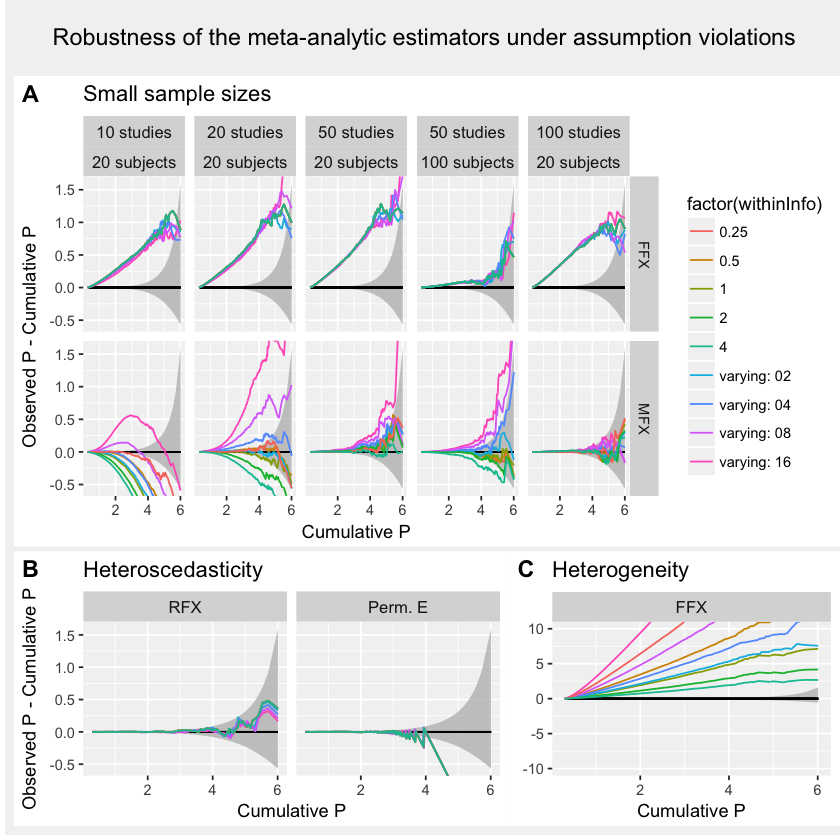

In [8]:
p <- robutness_plot(simu2)

# print on screen
print(p)

In [9]:
# Save to pdf
pdf(paste("robustness_test2.pdf", sep=""))
print(p)
dev.off()

pdf 
  2

### Unbalanced two-sample tests

In [10]:
simu3_k05 <- load_data_from_csv('^test3_k005_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k10 <- load_data_from_csv('^test3_k010_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k25 <- load_data_from_csv('^test3_k025_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k50 <- load_data_from_csv('^test3_k050_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k25_n100 <- load_data_from_csv('^test3_k025_n100.*_nominal.*', '/Volumes/camille/IBMA_simu/')

[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k005_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k010_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k025_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k050_n20_nominal.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k025_n100_nominal.csv"


In [11]:
simu3 <- rbind(
                    simu3_k05, 
                    simu3_k10, 
                    simu3_k25, 
                    simu3_k50,
                    simu3_k25_n100
)

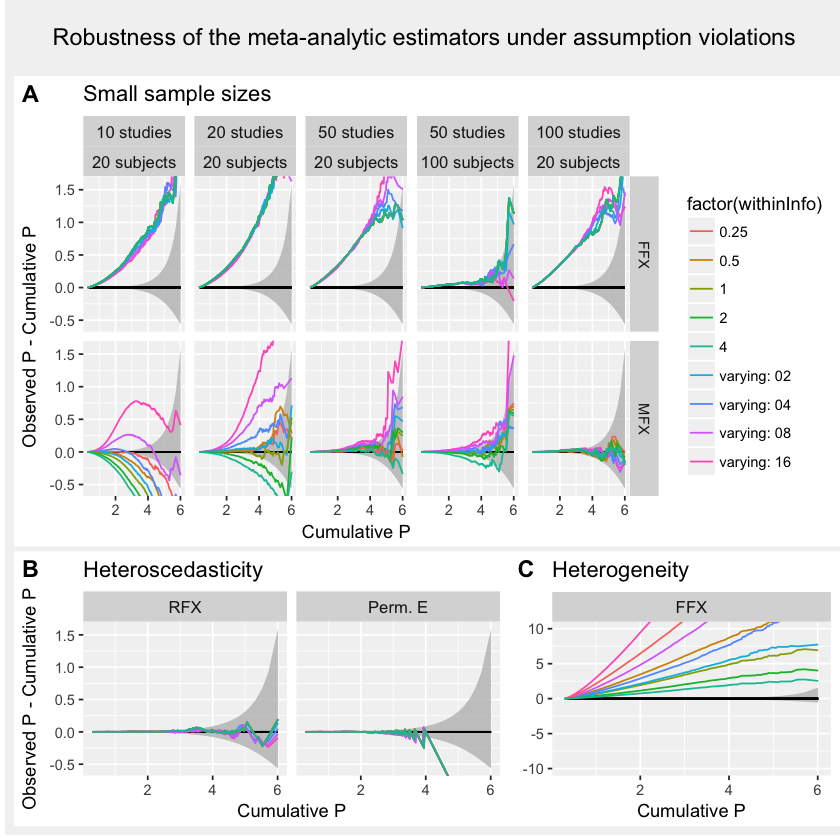

In [12]:
p <- robutness_plot(simu3)

# print on screen
print(p)

In [13]:
# Save to pdf
pdf(paste("robustness_test3.pdf", sep=""))
print(p)
dev.off()

pdf 
  2

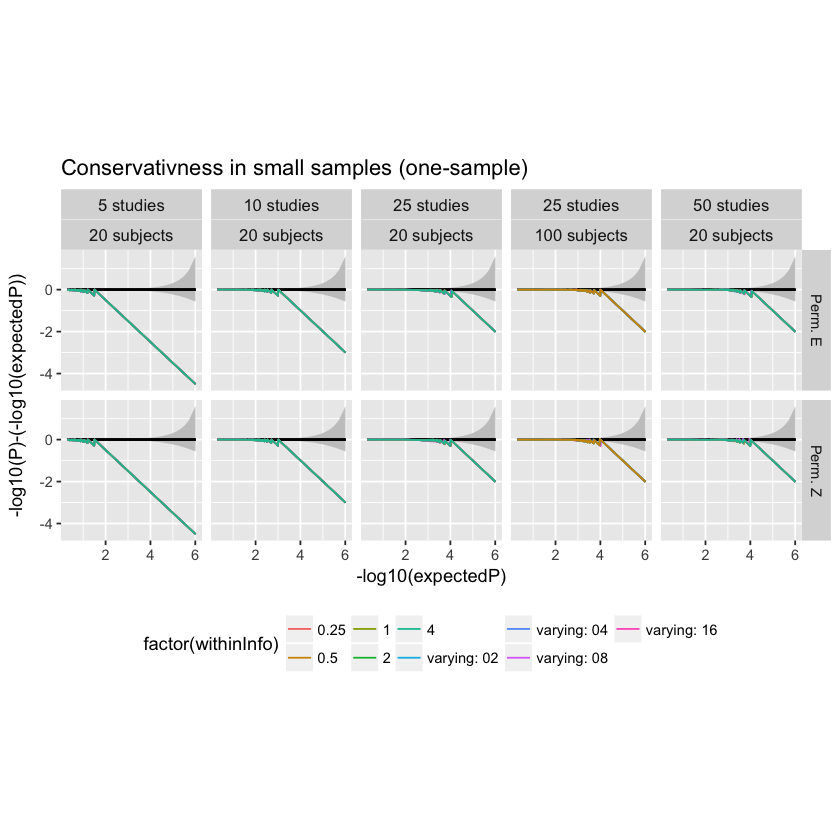

In [30]:
possibly_conservative_methods <- c("permutCon","permutZ")
p <- plot_qq_p(
    list(subset(data_under_rfx_assumption, methods %in% possibly_conservative_methods)), 
    formula=methods~nStudies+nSubjects, "Conservativness in small samples (one-sample)",
    mult=FALSE, lim=NA, filename=NA)
    

In [27]:
simu3_k05 <- load_data_from_csv('^test3_k005_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k10 <- load_data_from_csv('^test3_k010_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k25 <- load_data_from_csv('^test3_k025_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
simu3_k50 <- load_data_from_csv('^test3_k050_n20.*_nominal.*', '/Volumes/camille/IBMA_simu/')
# simu3_k25_n100 <- load_data_from_csv('^test3_k025_n100_.*', '/Volumes/camille/IBMA_simu/')

[1] "pattern= test3_k005_n20_nominal"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k005_n20_nominal.csv  not found, reprocessing the data."
[1] "^test3_k005_n20.*_nominal.*"
[1] "18 simulations"
[1] "Reading  18  /  18"
[1] "/Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff16_nominal/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff16_nominal/simu_400.csv does not exist."
[1] "Reading  17  /  18"
[1] "/Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff08_nominal/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff08_nominal/simu_400.csv does not exist."
[1] "Reading  16  /  18"
[1] "/Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff04_nominal/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff04_nominal/simu_400.csv does not exist."
[1] "Reading  15  /  18"
[1] "/Volumes/camille/IBMA_simu//test3_k005_n20_btw1_wthdiff02_nominal/simu_400

Warning message in file(file, "rt"):
“cannot open file '/Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test3_k005_n20_nominal.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


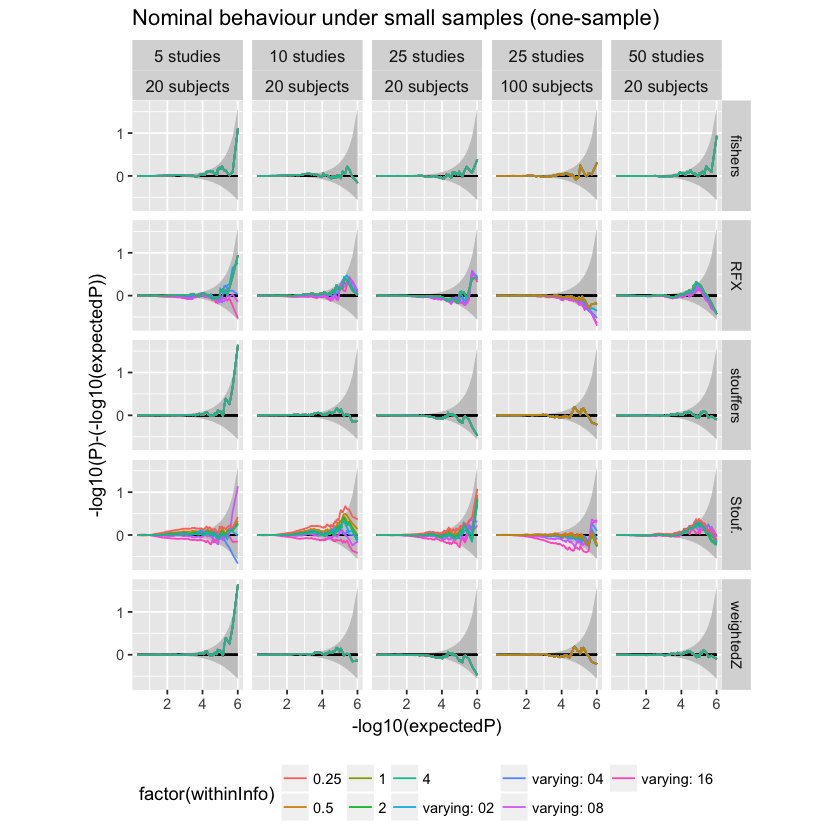

In [79]:
other_methods <- setdiff(unique(allsimudat$methods), 
                         union(large_sample_assumptions_methods, possibly_conservative_methods))
p <- plot_qq_p(
    list(subset(data_under_rfx_assumption, methods %in% other_methods)), 
    formula=methods~nStudies+nSubjects, "Nominal behaviour under small samples (one-sample)", 
    mult=FALSE, lim=NA, filename=NA)

## Two-sample tests

### Load data from CSV

In [6]:
allsimudat2_k05 <- load_data_from_csv('^test2_k005.*', '/Volumes/camille/IBMA_simu/')
allsimudat2_k25_n20 <- load_data_from_csv('^test2_k025_n20.*', '/Volumes/camille/IBMA_simu/')
allsimudat2_k50 <- load_data_from_csv('^test2_k050.*', '/Volumes/camille/IBMA_simu/')
allsimudat2_k25_n100 <- load_data_from_csv('^test2_k025_n100_.*', '/Volumes/camille/IBMA_simu/')

[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k005.csv"
[1] "Reading from  /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k025_n20.csv"
[1] "pattern= test2_k050"
[1] "CSV file /Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k050.csv  not found, reprocessing the data."
[1] "^test2_k050.*"
[1] "19 simulations"
[1] "Reading  19  /  19"
[1] "/Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft50_002/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft50_002/simu_400.csv does not exist."
[1] "Reading  18  /  19"
[1] "/Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft20_002/simu_400.csv"
[1] "/!  /Volumes/camille/IBMA_simu//test2_k050_n20_btw0_wthdiff04_datascl_soft20_002/simu_400.csv does not exist."
[1] "Reading  17  /  19"
[1] "/Volumes/camille/IBMA_simu//test2_k050_n20_btw0

Warning message in file(file, "rt"):
“cannot open file '/Users/cmaumet/Projects/Meta-analysis/dev/zmeta/small_samples/../data/allsimudat_test2_k050.csv': No such file or directory”

ERROR: Error in file(file, "rt"): cannot open the connection


In [ ]:
allsimudat2 <- rbind(
                    allsimudat2_k05, 
                    allsimudat2_k25_n20, 
                    allsimudat2_k25_n100,
                    allsimudat2_k50
)

In [ ]:
z_methods <- c("fishers", "stouffers", "stouffersMFX", "weightedZ", "permutZ")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% z_methods)

best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("fishers") & Between==0) | 
     (methods %in% c("stouffers") & Between==0)  |
     (methods %in% c("stouffersMFX") & Between==1)  |
     (methods %in% c("weightedZ") & Between==0) |
     (methods %in% c("permutZ") & Between==1)
    ) & (unitMism=="nominal"))

best_con_data_1_n20 <- subset(best_con_data_1, nSubjects==20)
best_con_data_1_n50 <- subset(best_con_data_1, nSubjects==50)
best_con_data_1_n100_k100 <- subset(best_con_data_1, nSubjects==100)


p <- plot_blandaldman_z(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    title="Bland-Altman Z-plots",
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)
p <- plot_qq_p(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    "Bland-Altman QQ-plots", 
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)

In [ ]:
z_methods <- c("fishers", "stouffers", "stouffersMFX", "weightedZ", "permutZ")
con_data_1 <- subset(allsimudat, is.finite(expectedz) & expectedz>0  &  methods %in% z_methods)

best_con_data_1 <- subset(con_data_1, 
    ((methods %in% c("fishers") & Between==1) | 
     (methods %in% c("stouffers") & Between==1)  |
     (methods %in% c("stouffersMFX") & Between==1)  |
     (methods %in% c("weightedZ") & Between==1) |
     (methods %in% c("permutZ") & Between==1)
    ) & (unitMism=="nominal"))

best_con_data_1_n20 <- subset(best_con_data_1, nSubjects==20)
best_con_data_1_n50 <- subset(best_con_data_1, nSubjects==50)
best_con_data_1_n100_k100 <- subset(best_con_data_1, nSubjects==100)


p <- plot_blandaldman_z(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    title="Bland-Altman Z-plots",
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)
p <- plot_qq_p(
    list(best_con_data_1), 
    formula=methods~unitMism+nStudies+nSubjects, 
    "Bland-Altman QQ-plots", 
    mult=FALSE, 
    lim=NA, max_z=18, filename=NA)

In [ ]:
unique(allsimudat$methods)